In [ ]:
import os
import textwrap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from matplotlib.gridspec import GridSpec
from matplotlib.colors import TwoSlopeNorm

from TimeMarkers import TimeWrap

from umap import UMAP
from scipy.stats import chi2_contingency

from constants import DATA_DIR, RANDOM_SEED, RNG
import nlp_functions as NF
import topic_sentences_plotting as TPlot

from importlib import reload

In [3]:
def reldir(parts):
    if isinstance(parts, str):
        return os.path.join(DATA_DIR, parts)
    else:
        return os.path.join(DATA_DIR, *parts)

In [16]:
products = pd.read_parquet(reldir('relevant_products.par')).drop(columns=['relevant', 'labeled'])

In [17]:
reviews = pd.read_parquet(reldir('relevant_reviews.par'))

reviews['datetime'] = pd.to_datetime(reviews['timestamp'])
reviews.drop(columns=['timestamp'], inplace=True)

reviews.sort_values('datetime', inplace=True)

# Get product title for each review
reviews = reviews.merge(products.reset_index()[['parent_asin', 'title']], how='left', on='parent_asin', suffixes=[None, '_product'])

reviews.drop_duplicates(inplace=True)
reviews.reset_index(drop=True, inplace=True)
review_text = reviews['text'].values

In [4]:
sent_encoded = pd.read_parquet(reldir('sentence_encoding.par')).to_numpy()

In [ ]:
reduced_encoded = pd.read_parquet(reldir('reduced_encoding.par')).to_numpy()

In [6]:
sentences_df = pd.read_parquet(reldir('sentence_topics.par'))

In [23]:
topics_summary = pd.read_csv(reldir('topic_summary_sent.csv'))
topic_names = topics_summary['Name'].values

In [38]:
# topic_embeddings
sent_encoded.shape
unique_sentences = sentences_df['sentences'].unique()
tmap = {unique_sentences[i]: i for i in range(len(unique_sentences))}

In [44]:
sentences_df['encoding'] = sentences_df['sentences'].apply(lambda x: sent_encoded[tmap[x]])

In [54]:
topic_encodings = np.vstack(sentences_df[['topic', 'encoding']].groupby('topic').mean()['encoding'].values)

In [10]:
coocurrances = sentences_df.reset_index()[['index', 'topic']].groupby('index').agg(list)
unique_topics = np.unique(sentences_df['topic'].values)
topic_cooc_mat = np.zeros((len(unique_topics), len(unique_topics)))
all_pairs = []
for row in coocurrances['topic'].values:
    pairs = list(combinations(np.unique(row), 2))
    all_pairs.extend(pairs)
    for a, b in pairs:
        topic_cooc_mat[a+1, b+1] += 1
        topic_cooc_mat[b+1, a+1] += 1

rowsum = topic_cooc_mat.sum(0, keepdims=True)
expected = (rowsum.T @ rowsum)/topic_cooc_mat.sum()
norm_cooc = topic_cooc_mat/expected

[1.09858021 1.08834225 1.06252099 1.02223648 1.04465105 1.05490029
 0.98064386 1.02483337 0.94461373 1.00921157 0.97726367 1.05435521
 1.01566621 1.01511374 0.96207532 1.03832825 0.93522206 1.05732139
 1.05038253 0.99767029 1.01644212 0.92488121 1.01727039 1.00938933
 1.04382755 0.95126199]


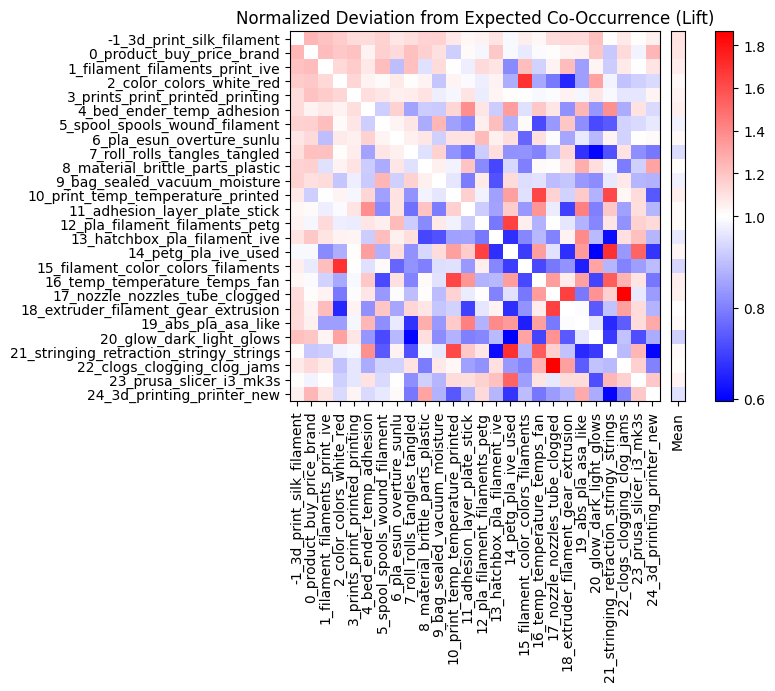

In [24]:
TPlot.plot_lift(norm_cooc, topic_names)

In [1]:
# tmp_cooc = norm_cooc.copy()
# tmp_cooc[np.eye(len(unique_topics)) > 0] = np.nan
# log_cooc = np.log10(tmp_cooc)*cramer_mat
# vlim = np.max(np.abs(log_cooc[~np.isnan(log_cooc)]))
# im = plt.imshow(log_cooc, cmap='bwr', vmin=-vlim, vmax=vlim)
# plt.colorbar(im)
# plt.show()

In [12]:
len(all_pairs)

547454

In [13]:
total_topics_per_review = sentences_df.reset_index()[['index', 'topic']].groupby('index').count()['topic'].mean()
mean_unique_topics_per_review = sentences_df.reset_index()[['index', 'topic']].drop_duplicates().groupby('index').count()['topic'].mean()
med_unique_topics_per_review = sentences_df.reset_index()[['index', 'topic']].drop_duplicates().groupby('index').count()['topic'].median()

In [14]:
print(med_unique_topics_per_review, mean_unique_topics_per_review)

2.0 2.9188779378316907


In [ ]:
def chi2_pair(A, B, a, b):
    AisA = A == a
    BisB = B == b

    AisB = A == b
    BisA = B == a
    
    both = np.logical_or(AisA*BisB, AisB*BisA).sum()
    neither = np.logical_and(~AisA*~BisB, ~AisB*~BisA).sum()
    a_not_b = np.logical_or(AisA*~BisB, BisA*~AisB).sum()
    b_not_a = np.logical_or(~AisA*BisB, ~BisA*AisB).sum()

    ctable = np.array([[both, a_not_b], [b_not_a, neither]])

    chi2, p, _, expected = chi2_contingency(ctable)
    return {'pair': (a, b), 'chi2': chi2, 'p_value': p, 'observed':ctable, 'expected': expected}


A, B = np.array(all_pairs).T
comp = []
for a, b in combinations(unique_topics, 2):
    comp.append(chi2_pair(A, B, a, b))

chi_df = pd.DataFrame(comp)
chi_df

,pair,chi2,p_value,observed,expected
0,"(-1, 0)",7845.154505,0.000000e+00,"[[19707, 111780], [112195, 303772]]","[[31680.101477019074, 99806.89852298093], [100..."
1,"(-1, 1)",7075.293977,0.000000e+00,"[[16411, 115076], [96744, 319223]]","[[27177.46419790521, 104309.53580209479], [859..."
2,"(-1, 2)",5091.450514,0.000000e+00,"[[11375, 120112], [69268, 346699]]","[[19368.761833870973, 112118.23816612903], [61..."
3,"(-1, 3)",7052.171418,0.000000e+00,"[[12782, 118705], [82307, 333660]]","[[22838.38887468171, 108648.61112531829], [722..."
4,"(-1, 4)",4819.499422,0.000000e+00,"[[9150, 122337], [59136, 356831]]","[[16400.86889857413, 115086.13110142587], [518..."
...,...,...,...,...,...
320,"(21, 23)",52.866865,3.569406e-13,"[[223, 15552], [12181, 519498]]","[[357.4238200835139, 15417.576179916487], [120..."
321,"(21, 24)",146.572365,9.732294e-34,"[[87, 15688], [9914, 521765]]","[[288.1808791240908, 15486.819120875909], [971..."
322,"(22, 23)",50.788429,1.028784e-12,"[[159, 11980], [12245, 523070]]","[[275.0407449758336, 11863.959255024167], [121..."
323,"(22, 24)",82.169109,1.249272e-19,"[[89, 12050], [9912, 525403]]","[[221.75769836369813, 11917.242301636303], [97..."


In [ ]:
chi_mat = np.zeros((len(unique_topics), len(unique_topics)))
pval_mat = np.zeros((len(unique_topics), len(unique_topics)))
for idx, row in chi_df.iterrows():
    a, b = row['pair']
    chi_mat[a+1, b+1] = row['chi2']
    chi_mat[b+1, a+1] = row['chi2']
    pval_mat[a+1, b+1] = row['p_value']
    pval_mat[b+1, a+1] = row['p_value']

# chi_out_df = pd.DataFrame(chi_mat, index=unique_topics, columns=unique_topics)
# chi_out_df.to_csv(reldir('chi_mat.csv'))
# pval_out_df = pd.DataFrame(pval_mat, index=unique_topics, columns=unique_topics)
# pval_out_df.to_csv(reldir('pval_mat.csv'))

In [17]:
chi_df['p_value'].mean()

np.float64(0.0005336520604127986)

In [18]:
tmp = chi_df.sort_values('p_value').reset_index()
tmp['BH_corr'] = (tmp.index.values+1)*0.01/len(tmp)
sum(tmp['p_value'] > tmp['BH_corr'])

1

In [ ]:
tmp['cramer'] = np.sqrt(tmp['chi2']/len(all_pairs))
cramer_mat = np.zeros((len(unique_topics), len(unique_topics)))
for idx, row in tmp.iterrows():
    a, b = row['pair']
    cramer_mat[a+1, b+1] = row['cramer']
    cramer_mat[b+1, a+1] = row['cramer']
np.max(cramer_mat)

,index,pair,chi2,p_value,observed,expected,BH_corr,cramer
0,0,"(-1, 0)",7845.154505,0.000000e+00,"[[19707, 111780], [112195, 303772]]","[[31680.101477019074, 99806.89852298093], [100...",0.000031,0.119709
1,1,"(-1, 1)",7075.293977,0.000000e+00,"[[16411, 115076], [96744, 319223]]","[[27177.46419790521, 104309.53580209479], [859...",0.000062,0.113684
2,2,"(-1, 2)",5091.450514,0.000000e+00,"[[11375, 120112], [69268, 346699]]","[[19368.761833870973, 112118.23816612903], [61...",0.000092,0.096438
3,3,"(-1, 3)",7052.171418,0.000000e+00,"[[12782, 118705], [82307, 333660]]","[[22838.38887468171, 108648.61112531829], [722...",0.000123,0.113498
4,4,"(-1, 4)",4819.499422,0.000000e+00,"[[9150, 122337], [59136, 356831]]","[[16400.86889857413, 115086.13110142587], [518...",0.000154,0.093827
...,...,...,...,...,...,...,...,...
320,314,"(19, 24)",24.684768,6.751568e-07,"[[121, 10194], [9880, 527259]]","[[188.43649877432625, 10126.563501225673], [98...",0.009877,0.006715
321,278,"(14, 23)",24.158331,8.873148e-07,"[[306, 17453], [12098, 517597]]","[[402.37652113236913, 17356.62347886763], [120...",0.009908,0.006643
322,297,"(17, 18)",15.522454,8.153101e-05,"[[387, 17653], [13889, 515525]]","[[470.4304653906995, 17569.5695346093], [13805...",0.009938,0.005325
323,276,"(14, 21)",12.084340,5.084709e-04,"[[435, 17324], [15340, 514355]]","[[511.7292503114417, 17247.27074968856], [1526...",0.009969,0.004698


In [ ]:
# tmp.to_csv(reldir('pair_stats.csv'))

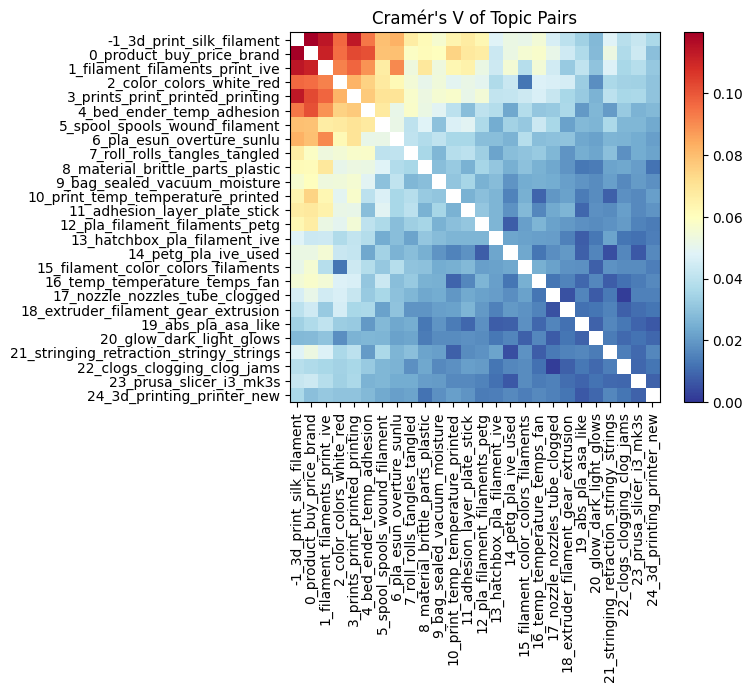

In [25]:
TPlot.plot_cramer(cramer_mat, topic_names)

In [421]:
reload(TPlot);

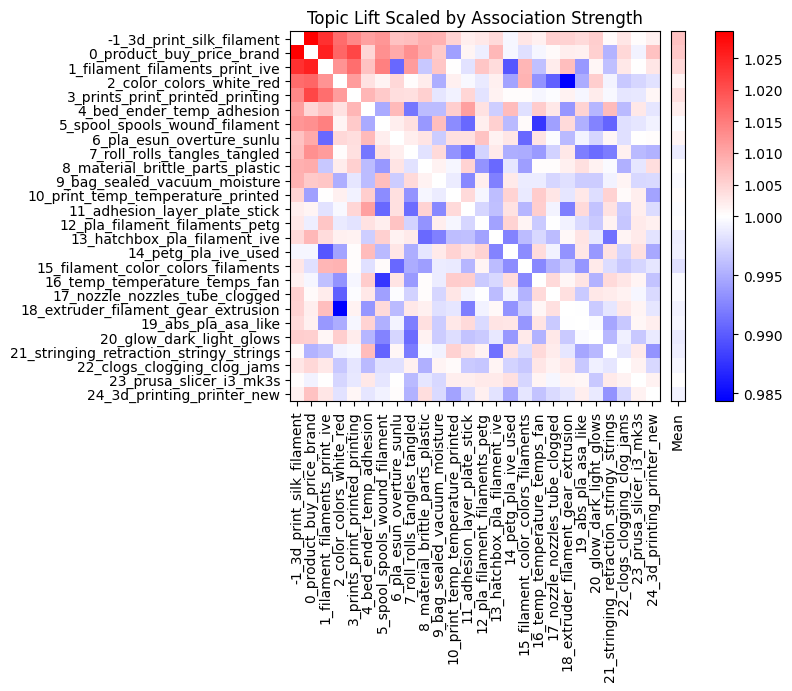

In [429]:
TPlot.plot_scaled_lift(norm_cooc, cramer_mat, topic_names, show_mean=True)

In [60]:
lift_sign = (norm_cooc>=1)*2-1
scaled_lift = cramer_mat*np.abs(norm_cooc-1)*lift_sign+1

In [ ]:
reduced_topic_embeddings = UMAP().fit_transform(topic_encodings)

In [65]:
scaled_lift[np.eye(len(scaled_lift))>0] = 1
topic_mean_scaled_lift = np.mean(scaled_lift, 1)

In [89]:
# s = topics_summary['Count'].values
# sctr = plt.scatter(*reduced_topic_embeddings.T, s=s/100, c=topic_mean_scaled_lift, cmap='bwr')
# plt.colorbar(sctr)
# for i, p in enumerate(reduced_topic_embeddings):
#     plt.text(*p, str(i-1))
# plt.show()

In [98]:
from sklearn.manifold import MDS, TSNE

In [193]:
distances = 1/scaled_lift-0.95
# distances = 1/norm_cooc-0.5

In [395]:
mds = TSNE(n_components=2, metric='precomputed', random_state=0, perplexity=10, init='random')
coords = mds.fit_transform(distances)

In [396]:
# umap = UMAP(metric='precomputed', random_state=0)
# coords = umap.fit_transform(distances)

In [ ]:
# from adjustText import adjust_text

In [285]:
# s = topics_summary['Count'].values
# norm = TwoSlopeNorm(1, np.min(topic_mean_scaled_lift), np.max(topic_mean_scaled_lift))
# sctr = plt.scatter(*coords.T, s=s/50, c=topic_mean_scaled_lift, cmap='bwr', norm=norm)
# # plt.colorbar(sctr)
# plt.gcf().set_size_inches(12, 7)
# ax = plt.gca()
# # ax.set_xmargin(0.75)
# # ax.set_ymargin(0.75)

# texts = []
# for i, p in enumerate(coords):
#     texts.append(plt.text(*p, topic_names[i]))

# adjust_text(texts, expand=(1.2, 2), expand_axes=True,
#             arrowprops=dict(arrowstyle='-', color='k'))
# plt.show()

In [397]:
cdists = np.zeros_like(scaled_lift)
for a, b in combinations(list(range(26)), 2):
    dist = np.sqrt((coords[a][0]-coords[b][0])**2+(coords[a][1]-coords[b][1])**2)
    cdists[a, b] = dist
    cdists[b, a] = dist

mean_cdist = np.mean(cdists)

In [398]:
coordinate_vec_mat = np.zeros((*scaled_lift.shape, 2))
for a, b in combinations(list(range(26)), 2):
    tmp = coords[a]-coords[b]
    norm = np.linalg.norm(tmp)
    coordinate_vec_mat[a, b, :] = tmp/norm
    coordinate_vec_mat[b, a, :] = -tmp/norm

In [399]:
tmp = scaled_lift.copy()
# tmp[(scaled_lift-1)<0.7*avg_scaled_lift] = 0
tmp[cdists > 0.5*mean_cdist] = 0
weighted_vecs = np.sum(tmp[..., None]/np.sum(tmp, 0)[:, None]*coordinate_vec_mat, 0)
weighted_vecs

array([[-0.20769062,  0.13063939],
       [ 0.10341739, -0.17863126],
       [ 0.11503763,  0.12468734],
       [ 0.10712329,  0.11498838],
       [ 0.22078189, -0.12089571],
       [ 0.02848983,  0.14032715],
       [ 0.00520832,  0.30114513],
       [-0.13426892,  0.43481122],
       [ 0.03955279,  0.5921076 ],
       [-0.06320472, -0.00281748],
       [-0.54897729, -0.0457413 ],
       [-0.37469342, -0.43791983],
       [-0.35814048,  0.3045517 ],
       [ 0.21938444,  0.14075912],
       [ 0.36483553,  0.03741605],
       [ 0.10291517, -0.02735414],
       [ 0.55589592, -0.12268968],
       [ 0.01369038, -0.31742309],
       [-0.34925464, -0.35899791],
       [ 0.11858847, -0.18753113],
       [ 0.13872282, -0.60517357],
       [-0.2369814 ,  0.56612697],
       [-0.48935306,  0.16393258],
       [ 0.33633679, -0.27911722],
       [ 0.42200238, -0.08108241],
       [-0.21921234, -0.47167863]])

In [366]:
import textalloc as ta

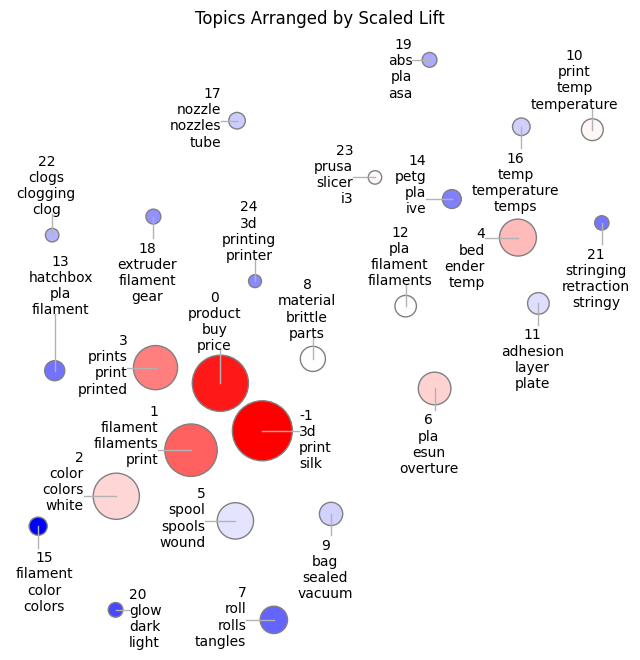

In [428]:
def plot_2D_euclidean_lift(cmap='plasma'):
    # thr = 0.5*mean_cdist
    # vmin = np.min(scaled_lift)
    # vmax = np.max(scaled_lift)
    # norm_lift = (scaled_lift-vmin)/(vmax-vmin)

    # avg_scaled_lift = np.mean(np.abs(scaled_lift-1))
    # std_scaled_lift = np.std(np.abs(scaled_lift-1))

    norm = TwoSlopeNorm(1, np.min(topic_mean_scaled_lift), np.max(topic_mean_scaled_lift))

    # for a, b in combinations(list(range(26)), 2):
    #     if cdists[a, b] < thr:
    #     # if (scaled_lift[a, b]-1) > avg_scaled_lift+std_scaled_lift:
    #         c = norm_lift[a, b]
    #         plt.plot(*coords[[a, b]].T, color=(c, 0, 1-c), linewidth=5, alpha=0.3)

    # scale = 100
    # for i, (a, b) in enumerate(coords):
    #     X = [a, a+weighted_vecs[i][0]*scale]
    #     Y = [b, b+weighted_vecs[i][1]*scale]
    #     plt.plot(X, Y)

    plt.gcf().set_size_inches(8, 8)
    # ax = plt.gca()
    # ax.set_xmargin(0.15)
    # ax.set_ymargin(0.15)
    s = topics_summary['Count'].values
    # c = np.mean(np.abs(scaled_lift-1), 1)
    c = topic_mean_scaled_lift
    sctr = plt.scatter(*coords.T, s=s/35, c=c, cmap=cmap, zorder=2, edgecolors='0.5', norm=norm)


    shortened_names = ['\n'.join(s.split('_')[:4]) for s in topic_names]
    # texts = []
    # for i, p in enumerate(coords):
    #     # texts.append(plt.text(*p, manual_labels[i], fontsize=10))
    #     texts.append(plt.text(*p, shortened_names[i]))

    ta.allocate(plt.gca(), *coords.T, shortened_names, linecolor='0.7', scatter_plot=sctr, nbr_candidates=450, textsize=10)

    # adjust_text(texts, expand=(1.2, 1.2), force_static=(0.3, 0.5), max_move=10, explode_radius=200,
    #             arrowprops=dict(arrowstyle='-', color='k'))

    # plt.text(0, 0, '\n'.join(topic_names), va='center')
    # plt.table([[t] for t in topic_names], loc='right', cellLoc='left', bbox=[1.02, 0, 0.6, 1])

    # plt.colorbar(sctr)

    plt.gca().set_axis_off()
    plt.title('Topics Arranged by Scaled Lift')

    plt.show()

plot_2D_euclidean_lift('bwr')

In [ ]:
# norm_cooc[np.eye(len(norm_cooc))>0] = np.nan
# cooc_sign = (norm_cooc>1)*2-1
# scaled = cramer_mat*np.abs(norm_cooc-1)*cooc_sign+1
# scaled[np.eye(len(scaled))>0] = 1
# pd.DataFrame(scaled, index=list(range(len(scaled))), columns=list(range(len(scaled)))).to_csv(reldir('scaled_lift_matrix.csv'))

In [309]:
chi_df.iloc[chi_df['p_value'].argmax(), :]

pair                                                 (17, 22)
chi2                                                 1.858092
p_value                                              0.172845
observed                      [[373, 17667], [11766, 517648]]
expected    [[400.0108867594355, 17639.989113240565], [117...
Name: 301, dtype: object

In [ ]:
# with open(reldir('pairs.csv'), 'w') as f:
#     f.write('\n'.join([f'{a},{b}' for a, b in np.array(all_pairs)+1]))

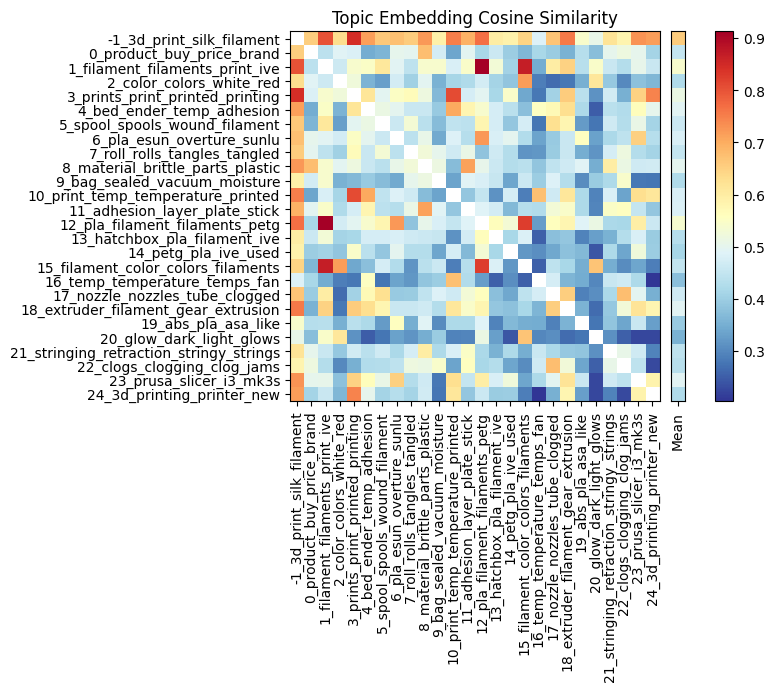

In [56]:
TPlot.plot_similarity(topic_encodings, topic_names)

In [ ]:
# np.mean(sim_mat_2[~np.isnan(sim_mat_2)])

np.float64(0.46789053323394614)

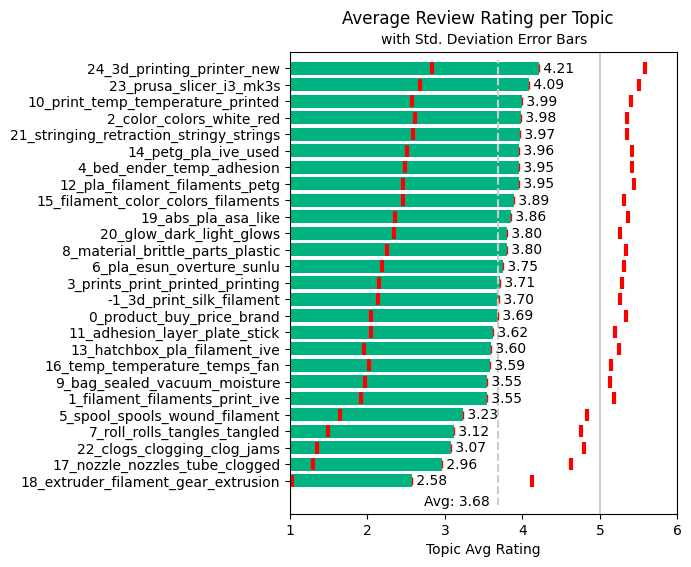

In [57]:
TPlot.plot_topic_ratings(sentences_df, topic_names)

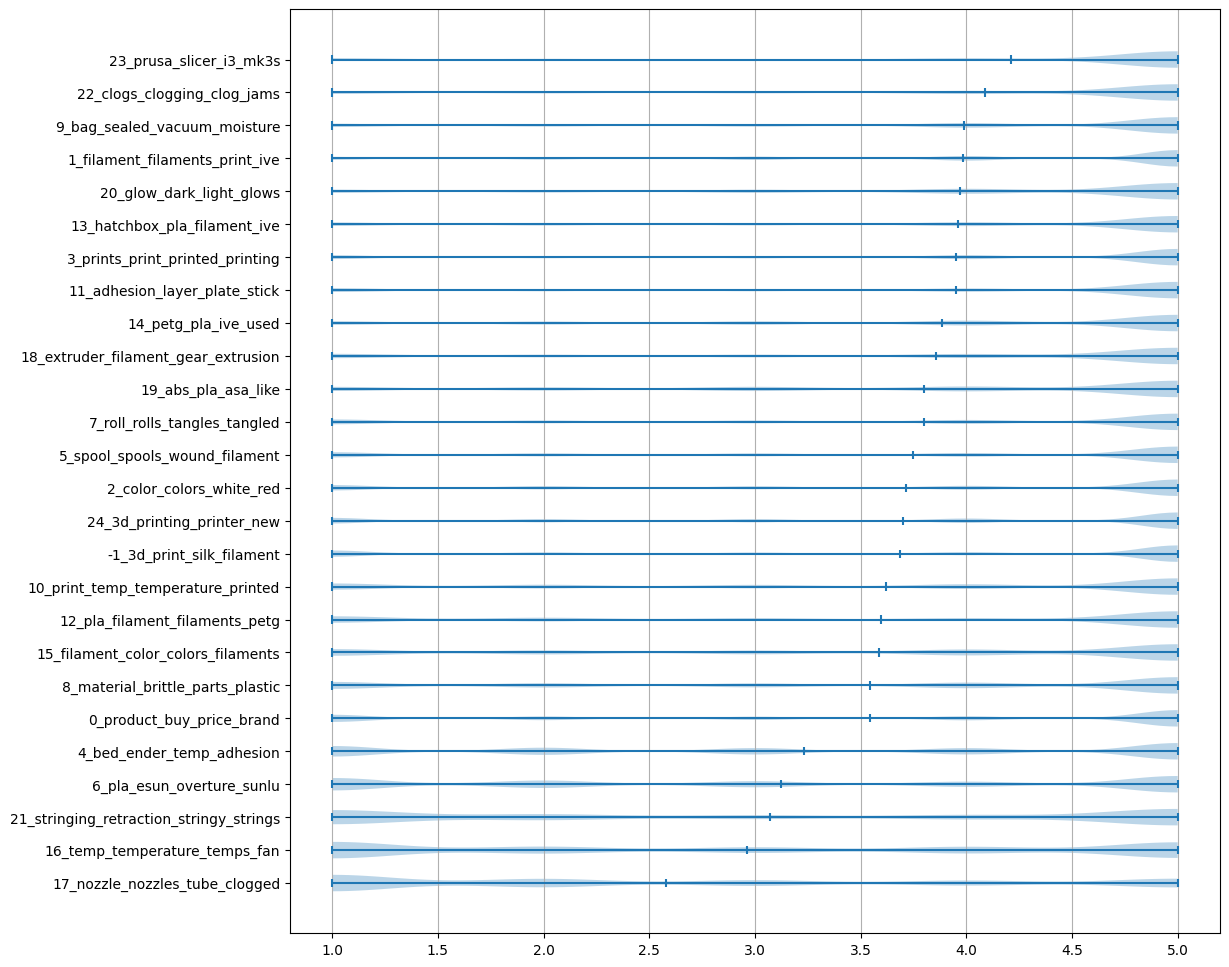

In [ ]:
# Hard to read

ratings_per_topic = sentences_df[["topic", "rating"]].groupby('topic').agg(list)
tlen = max([len(t) for t in ratings_per_topic['rating'].values])
ratings_per_topic['means'] = np.nanmean(np.vstack([t+[np.nan]*(tlen-len(t)) for t in ratings_per_topic['rating'].values]), 1)
ratings_per_topic.sort_values('means', inplace=True)

plt.violinplot(ratings_per_topic['rating'].values, range(len(topic_names)), orientation='horizontal', showmeans=True)
plt.yticks(range(len(topic_names)), topic_names[ratings_per_topic.index])

# # for i in range(len(topic_names)):
# #     ratings = ratings_per_topic.values[i][0]
# #     # plt.plot(ratings+RNG.normal(0, 0.1, len(ratings)), np.ones(len(ratings))*i+RNG.normal(0, 0.05, len(ratings)), '.', alpha=0.05)

plt.gcf().set_size_inches(12, 12)
plt.grid(axis='x')

plt.show()


In [503]:
ratings_per_topic = sentences_df[["topic", "rating"]].groupby('topic').agg(list)
tlen = max([len(t) for t in ratings_per_topic['rating'].values])
ratings_per_topic['means'] = np.nanmean(np.vstack([t+[np.nan]*(tlen-len(t)) for t in ratings_per_topic['rating'].values]), 1)
ratings_per_topic['counts'] = [np.unique(t, return_counts=True)[1] for t in ratings_per_topic['rating'].values]
# ratings_per_topic.sort_values('means', inplace=True)

N = len(ratings_per_topic)

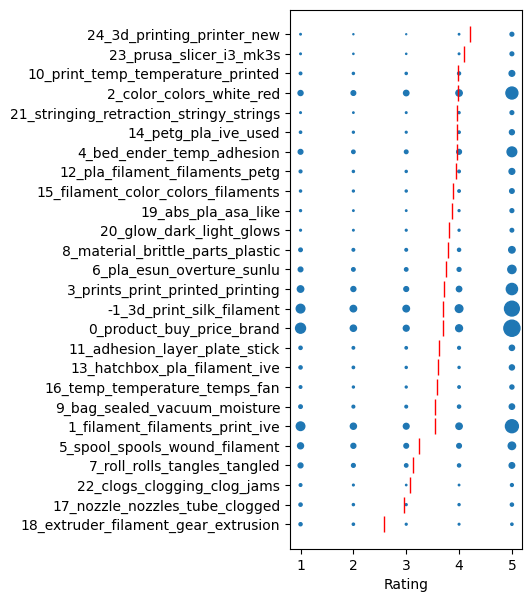

In [567]:
X = list(range(1, 6))
plt.scatter(X*N, np.tile(np.arange(1, N + 1).reshape(N, 1), (1, 5)).flatten(), s=np.vstack(ratings_per_topic['counts'].values).flatten()/300)
plt.plot(ratings_per_topic['means'].values, list(range(1, N+1)), 'r|', markersize=12)
plt.yticks(range(1, len(topic_names)+1), topic_names[ratings_per_topic.index+1])
plt.xticks(X, X)
plt.gcf().set_size_inches(3, 7)
plt.xlabel('Rating')
plt.show()

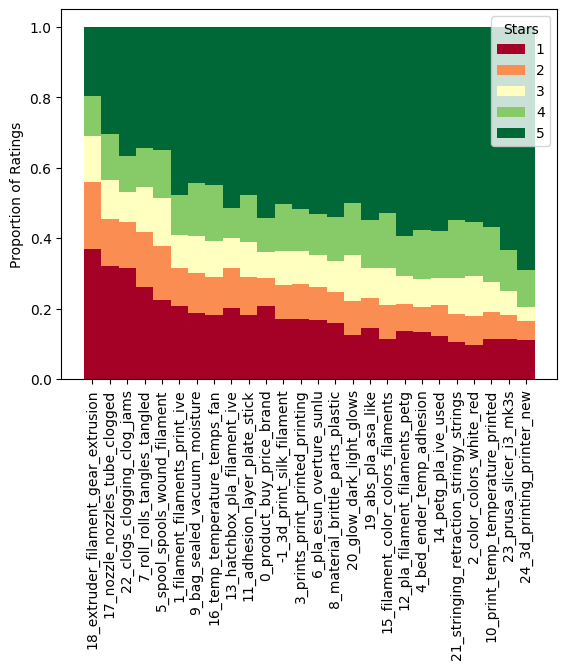

In [566]:
ratings_per_topic.sort_values('means', inplace=True)
rating_counts = np.vstack(ratings_per_topic['counts'].values)
norm_counts = (rating_counts/np.sum(rating_counts, 1)[:, None]).T

# plt.plot(norm_counts)
bottom = np.zeros(N)
cmap = plt.get_cmap('RdYlGn').resampled(5)
for i in range(5):
    plt.bar(range(N), norm_counts[i], 1, bottom=bottom, color=cmap(i))
    bottom += norm_counts[i]
plt.legend(range(1, 6), title='Stars')
plt.ylabel('Proportion of Ratings')
plt.xticks(range(N), topic_names[ratings_per_topic.index+1], rotation=90)
# plt.grid()
plt.show()

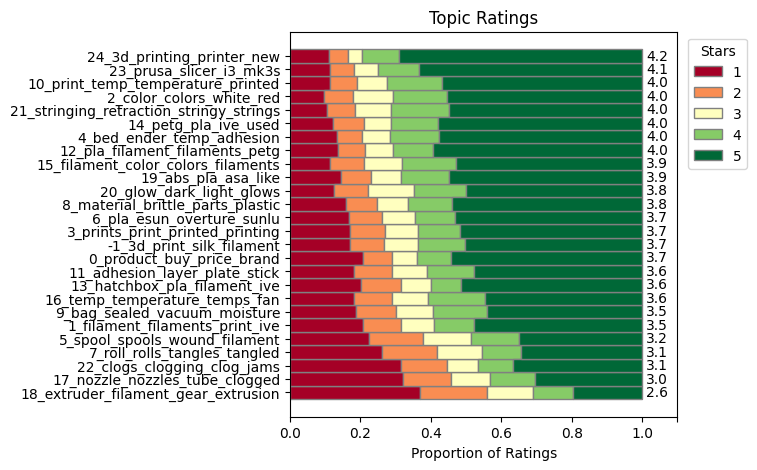

In [565]:
ratings_per_topic.sort_values('means', inplace=True)
# ratings_per_topic.sort_index(inplace=True)
rating_counts = np.vstack(ratings_per_topic['counts'].values)
norm_counts = (rating_counts/np.sum(rating_counts, 1)[:, None]).T

# plt.plot(norm_counts)
bottom = np.zeros(N)
cmap = plt.get_cmap('RdYlGn').resampled(5)
for i in range(5):
    bars = plt.barh(range(N), norm_counts[i], 1, left=bottom, color=cmap(i), edgecolor='0.5')
    bottom += norm_counts[i]
plt.legend(range(1, 6), title='Stars', 
        bbox_to_anchor=(1.01, 1),
        loc="upper left",)
plt.xlabel('Proportion of Ratings')
plt.yticks(range(N), topic_names[ratings_per_topic.index+1])
plt.title('Topic Ratings')
plt.gcf().set_size_inches(5, 5)

plt.bar_label(bars, [f'{m:.1f}' for m in ratings_per_topic['means'].values], label_type='edge', padding=3)
xticks = [0.2*i for i in range(6)] + [1.1]
plt.xticks(xticks, [f'{x:.1f}' if x <= 1 else '' for x in xticks])
# plt.grid()
plt.show()

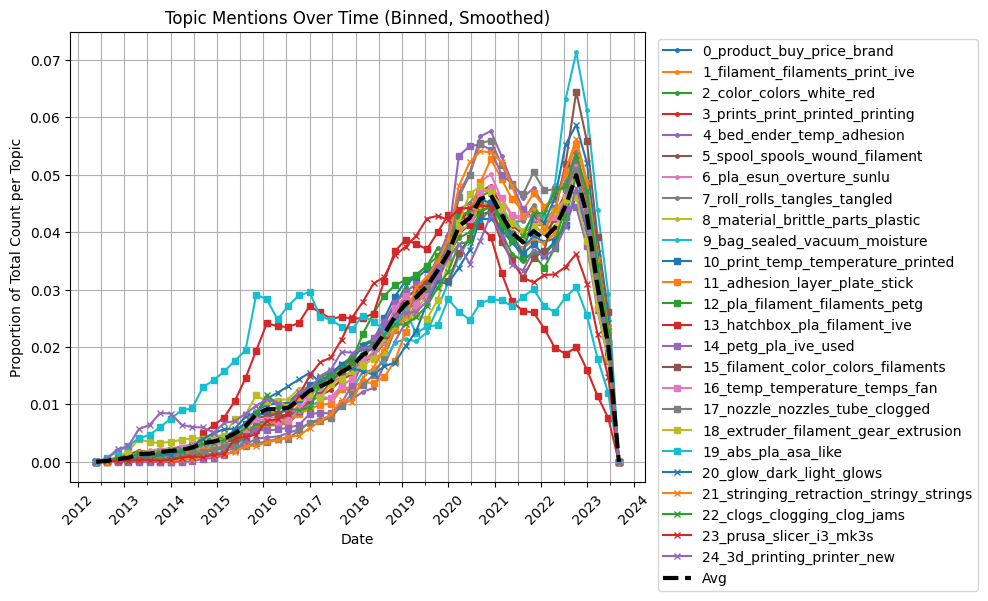

In [58]:
TPlot.plot_topics_over_time(sentences_df, topic_names)